# Multiple Linear Regression for MNIST Images






```
import torch
import torchvision
from torch.autograd import Variable
```


* torch: The core PyTorch library for building neural networks.

* torchvision: Provides popular datasets, model architectures, and image transformations. Useful for tasks like loading and transforming the MNIST dataset.

* Variable: Used in earlier versions of PyTorch to wrap tensors, allowing automatic differentiation. However, this is now mostly unnecessary in recent versions of PyTorch as tensors themselves support autograd.

# Hyperparameters:

```
n_epochs = 10
batch_size_train = 200
batch_size_test = 1000
learning_rate = 1e-3
momentum = 0.5
log_interval = 100

```
* n_epochs: The number of times the model will iterate over the entire training dataset.

* batch_size_train: The number of training samples processed before the model's parameters are updated.

* batch_size_test: The batch size used during testing/evaluation.

* learning_rate: The step size for the optimizer during gradient descent. Smaller values mean smaller updates, which can lead to more precise convergence but slower learning.

* momentum: A hyperparameter often used in optimizers like stochastic gradient descent to accelerate convergence by considering the past gradients.

* log_interval: The number of batches after which logs or status updates will be printed.

# Random Seed

```
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

```
* random_seed = 1: A fixed seed ensures that the results are reproducible by controlling randomness in the model's initialization and operations.

* torch.backends.cudnn.enabled = False: Disabling CUDA's cuDNN library to prevent non-deterministic behavior, though you can keep it enabled if performance is prioritized.

* torch.manual_seed(random_seed): Sets the manual seed for PyTorch's random number generator, ensuring the model behaves consistently across runs.

# GPU Availability Check:

```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

```

* torch.device(): Checks if a GPU is available (cuda:0). If so, it will use the GPU for computation; otherwise, it falls back to the CPU.

* print(device): Outputs the device being used (either cuda:0 or cpu).

# Difference from Previous Code

## Momentum and Learning Rate:
This code introduces momentum and learning rate for a gradient-based optimization algorithm, which were not present in the previous code. This suggests a gradient-based approach (e.g., stochastic gradient descent or Adam) instead of the closed-form solution used earlier.

##Epochs:
The code defines n_epochs, implying that the model will be trained over multiple passes through the data. Previously, the training was done on a single batch using a closed-form solution.

### Epoch Example
Let’s assume you have a dataset of 1,000 images and you are training with a batch size of 100:

In one epoch, the model will process the 1,000 images in batches of 100 images each. So, the model will perform 10 updates (1000 images / 100 batch size = 10 batches) to its weights.

If you set n_epochs = 10, it means that the model will go through the entire dataset 10 times, resulting in 100 updates (10 epochs × 10 batches per epoch).

###Why do we use multiple epochs?
* Insufficient Learning: In a single epoch, the model might not learn the patterns well enough because the weight updates based on each batch are incremental.

* Better Generalization: By passing through the data multiple times (with multiple epochs), the model has more opportunities to adjust its weights and improve its ability to generalize.

##Batch Sizes:
The introduction of batch_size_train and batch_size_test allows training and testing to happen in smaller mini-batches, making it possible to efficiently handle large datasets and potentially improve convergence through mini-batch gradient descent. Earlier, large batches were used in one shot.

#Practical Example:
If you're training a model on MNIST, with n_epochs = 10, the model will process the entire dataset 10 times. During training, the model will use batches of 200 images for updating the model parameters and will test in batches of 1000 images.

The learning_rate and momentum will affect how fast and efficiently the model learns over time.

In [1]:
import torch
import torchvision
from torch.autograd import Variable

n_epochs = 10
batch_size_train = 200
batch_size_test = 1000
learning_rate = 1e-3
momentum = 0.5
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Checking GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


# MNIST dataset is part of torchvision
## Divide MNIST into training, validation and test sets
## Use DataLoader iterator for loading data in batches

This section of the code deals with loading the MNIST dataset, splitting it into training, validation, and test sets, and creating data loaders that are responsible for fetching batches of data during the training and evaluation processes.

# Importing random_split


```
from torch.utils.data import random_split

```
random_split: This function is used to randomly divide a dataset into two or more subsets. In this case, it will split the MNIST dataset into training and validation sets.

# Downloading and Preprocessing the MNIST Dataset:


```
MNIST_training = torchvision.datasets.MNIST('/MNIST_dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ]))

MNIST_test_set = torchvision.datasets.MNIST('/MNIST_dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ]))

```
* torchvision.datasets.MNIST: Downloads the MNIST dataset (a popular handwritten digit dataset).

* train=True: Loads the training set.

* train=False: Loads the test set.

* download=True: Downloads the dataset if it is not already present in the specified directory.

* transform=torchvision.transforms.Compose([...]): Transforms the raw images. Here, it:
    1. Converts the images to tensors: This is necessary because PyTorch models work with tensors.

    2. Normalizes the images: The pixel values are normalized to have a mean of 0.1307 and a standard deviation of 0.3081 (common values for MNIST). This helps stabilize the learning process by keeping the input data on a similar scale.

# Splitting the Training Dataset:
```
MNIST_training_set, MNIST_validation_set = random_split(MNIST_training, [55000, 5000])

```
random_split(MNIST_training, [55000, 5000]): The MNIST training set, which contains 60,000 images, is split into two parts:
* Training set: 55,000 images.
* Validation set: 5,000 images. (Used to evaluate the model during training and tune hyperparameters.)

This split helps with hyperparameter tuning and prevents overfitting. The model is trained on the training set, and the validation set is used to assess performance and adjust parameters without seeing the test data.

# Creating Data Loaders:
```
train_loader = torch.utils.data.DataLoader(MNIST_training_set, batch_size=batch_size_train, shuffle=True)
validation_loader = torch.utils.data.DataLoader(MNIST_validation_set, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(MNIST_test_set, batch_size=batch_size_test, shuffle=True)

```
Data loader make it easy to handle data batching, shuffling, and loading.

* torch.utils.data.DataLoader: This is the PyTorch class that loads datasets in batches and shuffles them if needed.

* batch_size=batch_size_train: Defines how many samples are included in each batch during training and validation (as defined earlier: 200 for training).

* shuffle=True: Randomly shuffles the data at every epoch, which helps the model generalize better by preventing it from seeing the data in the same order every time.

* test_loader: Loads the test set in batches of 1000 images. (Used for the final evaluation of the model's performance after training is complete.)


In [2]:
from torch.utils.data import random_split


MNIST_training = torchvision.datasets.MNIST('/MNIST_dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

MNIST_test_set = torchvision.datasets.MNIST('/MNIST_dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

# create a training and a validation set
MNIST_training_set, MNIST_validation_set = random_split(MNIST_training, [55000, 5000])


train_loader = torch.utils.data.DataLoader(MNIST_training_set,batch_size=batch_size_train, shuffle=True)

validation_loader = torch.utils.data.DataLoader(MNIST_validation_set,batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST_test_set,batch_size=batch_size_test, shuffle=True)

OSError: [Errno 30] Read-only file system: '/MNIST_dataset'

## Check DataLoader
This section of code is responsible for fetching a batch of data from the test set and examining its structure (shape of the images and their corresponding labels). Let’s break down the steps:

# Enumerating the Data Loader


```
examples = enumerate(test_loader)

```
enumerate(test_loader): This converts the test_loader (which is a DataLoader object) into an enumerated object.

The enumerator returns both the batch index and the batch data (images and labels).

Since test_loader loads the test set in batches (as specified earlier with batch_size_test), examples will allow us to iterate over the batches of test data.

```
batch_idx, (example_data, example_targets) = next(examples)

```
* next(examples): This retrieves the next batch of data from the test_loader. In this case, since examples was just initialized, this will fetch the first batch from the test dataset.

* batch_idx: The index of the batch (the first batch will have batch_idx = 0).

* example_data: A tensor containing the images in the batch.
example_targets: A tensor containing the corresponding labels (digits) for each image in the batch.

```
print(example_data.shape)
print(example_targets.shape)

```

example_data.shape: This prints the shape of the image tensor (e.g., how many images are in the batch and the dimensions of each image).

If the batch size is 1000, and each image is a 28x28 grayscale image, the shape would be [1000, 1, 28, 28].

* 1000: The number of images in the batch.
* 1: The number of channels (grayscale images have one channel).
* 28, 28: The height and width of each image.

example_targets.shape: This prints the shape of the labels tensor (i.e., how many labels correspond to the images in the batch). If the batch contains 1000 images, the shape will be [1000], representing the labels for those 1000 images.

## Example Output:

Assume batch_size_test = 1000. When you run this code, it might print something like this:

torch.Size([1000, 1, 28, 28])
torch.Size([1000])

This tells you that:

1. The first batch contains 1000 images, each of size 28x28 pixels.
2. There are 1000 corresponding labels (one for each image).




In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000])


## Also, make sure to display some images

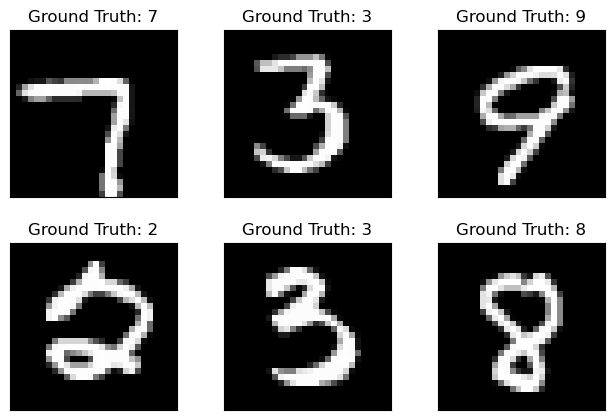

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])



```
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
```


* torch.nn: The module that provides neural network components (e.g., layers).

* torch.nn.functional: Contains functions for commonly used neural network operations like activation functions and loss functions.

* torch.optim: Provides optimization algorithms, such as SGD, Adam, etc.

* Variable: Used in earlier versions of PyTorch for wrapping tensors to allow automatic differentiation, though this is mostly redundant in recent versions.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Multiple Linear regression

This section of code defines a Multiple Linear Regression model using PyTorch’s neural network module (torch.nn). The model will be used to classify the MNIST dataset, which consists of 28x28 grayscale images of handwritten digits. In this case, the task is to map each 28x28 image to one of 10 digits (0-9).

# Defining the Model Class:


```
class MultipleLinearRegression(nn.Module):
    def __init__(self):
        super(MultipleLinearRegression, self).__init__()
        self.fc = nn.Linear(28*28, 10)

```
* class MultipleLinearRegression(nn.Module): This defines the model class for multiple linear regression. By inheriting from nn.Module, the model can make use of all the functionalities provided by PyTorch’s neural network module.

* __init__(self): The constructor method initializes the layers of the model.

* self.fc = nn.Linear(28*28, 10):
  * This defines a fully connected (dense) layer, which takes the flattened 28x28 pixel image (784 input features) and outputs 10 values (corresponding to the 10 digits).
  * Input size: 28*28 (784 features).
  * Output size: 10 (each representing one of the digit classes: 0-9).

# Forward Pass (Prediction):
```
def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

```
def forward(self, x): This defines the forward pass, which describes how the input data is transformed as it passes through the layers of the model.

## Flattening the Input:
```
x = x.view(x.size(0), -1)

```
* x.size(0): Refers to the batch size (the number of images in a batch).

* x.view(x.size(0), -1): Flattens each image from a 2D shape (28x28) into a 1D vector of 784 elements. This is necessary because the fully connected layer expects a flat vector as input, not a 2D matrix.

* For example, an MNIST batch of 200 images (batch size 200) would change shape from [200, 1, 28, 28] (200 grayscale images) to [200, 784] (200 flattened 28x28 images).

## Applying the Linear Layer:
```
x = self.fc(x)

```
The input data x is passed through the fully connected layer (fc), which maps the 784 input features to 10 outputs (each representing one digit).

## Returning the Output:
```
return x

```
The output of the forward pass is a tensor of shape [batch_size, 10], where each value corresponds to the predicted score (logits) for each digit (0-9).

# Example of Input and Output:
Input: A batch of MNIST images of shape [batch_size, 1, 28, 28]. After flattening, the input becomes [batch_size, 784].

Output: A tensor of shape [batch_size, 10], where each row contains 10 values representing the logits (unnormalized scores) for each digit class (0-9). You can apply a softmax function to these logits to interpret them as probabilities for each digit.

# Difference from Previous Code:
1. **Introduction of a Neural Network Model:**
This code defines a neural network using the nn.Module class, which was not part of the earlier code. Previously, the model was a linear regression-based solution where weights were computed using closed-form solutions. Now, the model uses a more flexible neural network that can be trained using gradient descent and backpropagation.

2. **Linear Layer (nn.Linear):**
This is a learnable layer with weights that can be updated during training, whereas the previous approach used a fixed set of weights calculated via a closed-form solution. The flexibility of nn.Linear allows for more powerful learning through iterative optimization (e.g., gradient descent).

3. **Forward Method:**
The forward() method defines how the input data moves through the model (input → flatten → linear layer → output). In previous code chunks, the model was more manual, relying on specific functions for prediction rather than an end-to-end neural network framework.

In [ ]:
# Multiple Linear regression
class MultipleLinearRegression(nn.Module):
    def __init__(self):
        super(MultipleLinearRegression, self).__init__()
        self.fc = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

This section of the code sets up the model, defines the optimizer for training, and prepares for one-hot encoding of the target labels.

# Model Initialization and Moving to Device:


```
multi_linear_model = MultipleLinearRegression().to(device)

```
* MultipleLinearRegression(): This creates an instance of the MultipleLinearRegression model that you defined earlier. It contains a single fully connected layer (nn.Linear(28*28, 10)), which is designed to take in the flattened MNIST images and output a prediction for one of the 10 digits (0-9).

* .to(device): Moves the model to the appropriate computing device, either CPU or GPU (cuda:0), depending on what was detected earlier in the code. This ensures that all computations for the model will happen on the correct hardware.

# Defining the Adam Optimizer:
```
optimizer = optim.Adam(multi_linear_model.parameters(), lr=learning_rate)
```
* optim.Adam: This defines the Adam optimizer, which is an adaptive learning rate optimization algorithm. Adam is one of the most popular optimizers because it combines the benefits of both SGD (stochastic gradient descent) and RMSProp by using momentum and adaptive learning rates.

Why Adam?:
It’s a robust and efficient optimizer that works well for many tasks. Unlike vanilla SGD, Adam adapts the learning rate for each parameter and uses momentum to accelerate convergence.

* multi_linear_model.parameters(): This passes all the parameters (weights and biases) of the MultipleLinearRegression model to the optimizer. The optimizer will update these parameters during training to minimize the loss.

* lr=learning_rate: This sets the learning rate (defined earlier as 1e-3). The learning rate controls how large a step the optimizer takes during each update.

#One-Hot Encoding:
```
one_hot = torch.nn.functional.one_hot

```
torch.nn.functional.one_hot: This function will be used to one-hot encode the target labels. One-hot encoding is a process where a categorical variable (e.g., digit labels 0-9) is converted into a binary vector representation. Each class (digit) is represented by a vector where only one element is 1, and the rest are 0s.

For example:

Digit 2 → [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

Digit 7 → [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

This is important for classification tasks, especially when using loss functions like cross-entropy, which expect the target to be a one-hot encoded vector.

# How It Works Together:

Model (multi_linear_model):
The MultipleLinearRegression model will take an MNIST image as input, flatten it to 784 features, and then output a set of 10 logits (one for each class, 0-9). These logits are the model's "raw" predictions before they are converted into probabilities (usually with softmax).

Optimizer (optimizer):
The Adam optimizer will adjust the model’s parameters (weights and biases) during training to reduce the error/loss between the predicted logits and the true labels. It uses the specified learning rate (1e-3) for this.

One-Hot Encoding (one_hot):
The true labels (e.g., digits 0-9) are converted into one-hot encoded vectors. These vectors will be compared against the model's predictions during training to compute the loss.

# How it Differs from Previous Code:

Model Training Setup:
In previous code snippets, there was no optimizer for training. The earlier approach relied on closed-form solutions (like estimating parameters using direct matrix operations). This code, however, sets up an iterative training process using the Adam optimizer, which is more typical for deep learning models.

Gradient-Based Optimization:
The use of Adam represents a shift from the earlier approach (which didn’t use gradient descent). This optimizer will calculate gradients of the loss function and update the model’s parameters accordingly after every batch of data.

One-Hot Encoding:
The introduction of one-hot encoding suggests that the model will be trained using a classification loss function, like cross-entropy, which expects the target labels to be in a one-hot encoded form. This was not explicitly addressed in the earlier code.



In [ ]:
multi_linear_model = MultipleLinearRegression().to(device)
optimizer = optim.Adam(multi_linear_model.parameters(), lr=learning_rate)

one_hot = torch.nn.functional.one_hot


This function defines the training loop for one epoch of the model. The goal is to iterate over the dataset, compute predictions, calculate the loss, and update the model’s parameters using backpropagation.

# Function Definition:


```
def train(epoch, data_loader, model, optimizer):

```
* epoch: Indicates the current epoch (iteration over the entire dataset). Typically, the model is trained over multiple epochs to improve performance.

* ata_loader: The training data loader that provides batches of images and their corresponding labels.
model: The neural network model being trained (in this case, MultipleLinearRegression).

* optimizer: The optimization algorithm (in this case, Adam), which updates the model’s parameters based on the computed gradients.

# Iterating Over Batches:


```
for batch_idx, (data, target) in enumerate(data_loader):

```
* enumerate(data_loader): Loops through the dataset in mini-batches. For each iteration, data_loader returns a batch of input images (data) and their corresponding labels (target).

* batch_idx: The index of the current batch. This is useful for tracking progress and logging status updates.

# Move Data to the Appropriate Device:
```
data = data.to(device)
target = target.to(device)

```
.to(device): Moves the batch of data and labels to the specified device (CPU or GPU). This ensures that all computations are performed on the same hardware (important when using GPUs for faster computation).

# Zeroing the Gradients:
```
output = model(data)

```
optimizer.zero_grad(): Clears the old gradients from the previous step. This is necessary because, in PyTorch, gradients accumulate by default, so you need to reset them before computing new gradients during backpropagation.

# Model Prediction:
```
output = model(data)

```
model(data): Passes the input data (images) through the model to get predictions. The output will be a tensor of shape [batch_size, 10], representing the logits for each class (0-9) for each image in the batch.

# Calculating Loss:
```
loss = F.mse_loss(output, one_hot(target, num_classes=10).float())

```
* F.mse_loss(): Calculates the mean squared error (MSE) loss between the model’s predictions (output) and the true one-hot encoded labels.

* output: The model’s predictions (logits) for each class.
one_hot(target, num_classes=10).float(): Converts the true labels (target) into one-hot encoded vectors (0-9) for use in the loss function. The .float() ensures that the labels are in floating-point format, which is necessary for MSE loss.

Why MSE Loss?
Typically, for classification tasks, cross-entropy loss is used instead of MSE loss, as cross-entropy is better suited for measuring the difference between probabilities. However, in this case, MSE loss is being used, which penalizes the difference between the predicted values and the one-hot encoded targets.

# Backpropagation:
```
loss.backward()

```
loss.backward(): Computes the gradients of the loss with respect to the model’s parameters using backpropagation. These gradients will be used to update the model’s weights during optimization.

# Optimizer Step:

```
optimizer.step()

```
optimizer.step(): Updates the model’s parameters using the gradients computed during loss.backward(). This is where the model’s weights are adjusted to minimize the loss.

# Logging Training Progress:

```
if batch_idx % log_interval == 0:
  print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
    epoch, batch_idx * len(data), len(data_loader.dataset),
    100. * batch_idx / len(data_loader), loss.item()))

```
* if batch_idx % log_interval == 0: Logs the training progress after every log_interval number of batches. This helps track the model’s performance throughout the epoch.

* print(...): Displays information such as:
  * The current epoch.
  * The number of samples processed so far (batch_idx * len(data)).
  * The total number of samples in the dataset (len(data_loader.dataset)).
  * The percentage of the dataset processed so far (100. * batch_idx / len(data_loader)).
  * The current loss (loss.item()).

# How It Differs from the Previous Code:

* Batch Training:
In previous code examples, you did not have an explicit training loop. The current code introduces a typical mini-batch training loop where the model is trained using gradient descent over batches of data. The model parameters are updated after processing each mini-batch.

* Loss Function:
The earlier approach did not explicitly define a loss function. Here, you are using mean squared error (MSE) loss, which is a standard way to compute how far the model’s predictions are from the true labels. However, for classification tasks, cross-entropy loss is usually more effective.

* Optimizer:
The previous code relied on closed-form solutions for finding weights. In this code, you're using the Adam optimizer to iteratively adjust the model's parameters based on the gradients computed from the loss function. This allows the model to "learn" from the data gradually over multiple epochs.

## Suggested Changes:
Since this is a classification problem, you might want to use cross-entropy loss instead of MSE loss. Cross-entropy is better suited for multi-class classification tasks like MNIST.

Here’s an alternative approach using cross-entropy loss:

loss = F.cross_entropy(output, target)

F.cross_entropy(): Automatically applies softmax to the output and calculates the cross-entropy loss between the predictions and the true labels (without needing to one-hot encode the targets).

In [ ]:
def train(epoch,data_loader,model,optimizer):
  for batch_idx, (data, target) in enumerate(data_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.mse_loss(output, one_hot(target,num_classes=10).float())
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(data_loader.dataset),
        100. * batch_idx / len(data_loader), loss.item()))


This function defines the evaluation process for a trained model on either the validation or test datasets. It computes the model’s loss and accuracy without modifying the model’s parameters (as we're not updating gradients in evaluation mode).

# Function Definition:


```
def eval(data_loader, model, dataset):

```
* data_loader: The loader for the dataset to be evaluated (either validation or test set).
* model: The trained model whose performance is being evaluated.
* dataset: A string indicating which dataset is being evaluated (e.g., "validation" or "test"), so that it can be printed in the output log.


# Tracking Loss and Accuracy:
```
loss = 0
correct = 0

```
* loss: Accumulates the total loss across all batches in the dataset.
* correct: Counts the number of correctly predicted samples.

# No Gradient Calculation:
```
with torch.no_grad():

```
torch.no_grad(): Disables gradient computation during evaluation, as gradients are not needed for inference (this reduces memory usage and speeds up computations). This is critical because evaluation should only compute predictions, not update model weights.

# Iterating Over Batches:

```
for data, target in data_loader:
  data = data.to(device)
  target = target.to(device)

```
* for data, target in data_loader: Iterates over the dataset batch by batch, where data is the batch of images and target is the batch of labels.
* data.to(device) and target.to(device): Moves the data and labels to the specified device (CPU or GPU) for computation.

# Model Prediction:

```
output = model(data)

```
model(data): Passes the input data (images) through the model to get the predicted outputs. The output is a tensor of shape [batch_size, 10], representing the logits for each class (0-9).

# Calculating Predictions:
```
pred = output.data.max(1, keepdim=True)[1]

```
* output.data.max(1, keepdim=True)[1]: This finds the index of the maximum value (logit) along dimension 1 (which corresponds to the 10 possible digit classes). This index is the predicted class for each input sample.
  * For example, if the output logits are [0.1, 0.9, 0.05, ..., 0.02], the maximum value is 0.9, corresponding to class 1.
* pred: Holds the predicted class labels for the batch.

# Counting Correct Predictions:

```
correct += pred.eq(target.data.view_as(pred)).sum()

```
* pred.eq(target.data.view_as(pred)): Compares the predicted labels (pred) with the true labels (target). It returns a tensor of True or False values for each comparison.
* sum(): Counts how many predictions are correct by summing the True values.

#  Calculating Loss:

```
loss += F.mse_loss(output, one_hot(target, num_classes=10).float(), size_average=False).item()

```
* F.mse_loss(output, one_hot(target, num_classes=10).float(), size_average=False): Computes the mean squared error (MSE) loss between the predicted logits (output) and the one-hot encoded true labels (target).

* size_average=False: Accumulates the loss over all elements without averaging. This is necessary because you want the total loss across the entire dataset rather than the average per batch.

* .item(): Extracts the scalar value of the loss from the tensor.

#  Average Loss:

```
loss /= len(data_loader.dataset)

```
loss /= len(data_loader.dataset): Averages the total loss over all samples in the dataset to get the average loss per sample.


# Printing the Results:

```
print(dataset + 'set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    loss, correct, len(data_loader.dataset), 100. * correct / len(data_loader.dataset)))

```

* dataset: Prints whether the evaluation is on the "validation" or "test" set.
* loss: Displays the average loss per sample.
* correct: The number of correctly classified samples.
* len(data_loader.dataset): The total number of samples in the dataset.
* 100. x correct / len(data_loader.dataset): Calculates and displays the accuracy as a percentage.

# How It Differs from the Training Code:

* No Gradients:
In contrast to the training loop, the evaluation loop uses torch.no_grad() to disable gradient calculations. This makes evaluation faster and more memory-efficient since no gradients are needed for inference.

* No Weight Updates:
Unlike the training loop, this function doesn’t call optimizer.zero_grad(), loss.backward(), or optimizer.step(). The purpose of evaluation is to measure the model's performance, not to update its parameters.

* Mean Squared Error Loss:
Like the training function, this evaluation function uses mean squared error (MSE) loss, which is not typical for classification tasks. Normally, you would use cross-entropy loss for classification.

You might want to replace this with cross-entropy loss for better evaluation of the model’s performance on a classification task.

# Suggested Changes (Optional):
Since the task is multi-class classification, using cross-entropy loss might be more appropriate than MSE loss.
Here’s how you can adjust the loss calculation:

```
loss += F.cross_entropy(output, target, reduction='sum').item()
```

* F.cross_entropy(): Computes the cross-entropy loss, which is commonly used for classification tasks. It measures the difference between the predicted probability distribution (after applying softmax to the logits) and the true distribution.

* reduction='sum': Accumulates the loss across all samples in the batch (similar to how size_average=False was used in MSE loss).



In [ ]:
def eval(data_loader,model,dataset):
  loss = 0
  correct = 0
  with torch.no_grad(): # notice the use of no_grad
    for data, target in data_loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
      loss += F.mse_loss(output, one_hot(target,num_classes=10).float(), size_average=False).item()
  loss /= len(data_loader.dataset)
  print(dataset+'set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(loss, correct, len(data_loader.dataset), 100. * correct / len(data_loader.dataset)))

This section of code ties together the training and evaluation functions to complete the training process across multiple epochs and evaluate the model's performance on the validation and test datasets.

# Initial Validation:


```
eval(validation_loader, multi_linear_model, "Validation")

```
* Before starting the training process, the code evaluates the model's performance on the validation set using the eval() function. This provides a baseline to compare the model's performance after training.
* Purpose: Understand how the model performs with random initialization before training, giving you an idea of how much improvement occurs during training.

# Training and Validation Loop:

```
for epoch in range(1, n_epochs + 1):
  train(epoch, train_loader, multi_linear_model, optimizer)
  eval(validation_loader, multi_linear_model, "Validation")

```

* for epoch in range(1, n_epochs + 1): This is the main training loop, which will run for n_epochs epochs (defined earlier as 10 epochs, for example).

  For each epoch:

  * Training: The model is trained on the training set using the train() function. In this function, the model’s parameters are updated using backpropagation and the optimizer.
  * Validation: After each epoch, the model is evaluated on the validation set using the eval() function. This provides feedback on how well the model generalizes to unseen data during training.

* Purpose: The validation step after each epoch allows you to track the model's performance and ensure it is improving over time without overfitting to the training set.

# Final Test Evaluation:

```
eval(test_loader, multi_linear_model, "Test")

```
* After training is complete (after all epochs), the model is evaluated on the test set using the eval() function.
* Purpose: The test set provides a final measure of how well the model performs on completely unseen data. Since the test set is only evaluated after the training process is complete, it serves as an unbiased assessment of the model’s performance.

# Differences from Previous Code:

* Epoch Loop:
This code introduces the concept of training the model over multiple epochs (iterations over the entire dataset). Previously, there was no explicit handling of epochs.
By repeating the training process over multiple epochs, the model has more chances to learn and improve its predictions.

* Validation After Each Epoch:
After every epoch, the model’s performance is evaluated on the validation set. This allows you to monitor how the model is generalizing as it learns.
If the validation performance improves, it indicates the model is learning well. If it deteriorates, it could suggest overfitting.

* Test Evaluation:
After training is complete, the model is evaluated on the test set, which is completely independent of the training and validation data. This gives a reliable measure of the model's final performance.


# Suggested Improvements:

* Switch to Cross-Entropy Loss:
If you're working with a classification problem like MNIST, it’s generally better to use cross-entropy loss rather than MSE loss for both training and evaluation. Cross-entropy is more suited to classification tasks as it penalizes the model more for incorrect class predictions.

Update in the training loop:
```
loss = F.cross_entropy(output, target)
```


In [ ]:
eval(validation_loader,multi_linear_model,"Validation")
for epoch in range(1, n_epochs + 1):
  train(epoch,train_loader,multi_linear_model,optimizer)
  eval(validation_loader,multi_linear_model,"Validation")

eval(test_loader,multi_linear_model,"Test")

C:\Users\nil_r\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Validationset: Avg. loss: 3.5394, Accuracy: 684/5000 (14%)

Train Epoch: 1 [0/55000 (0%)]	Loss: 0.351442
Train Epoch: 1 [20000/55000 (36%)]	Loss: 0.053855
Train Epoch: 1 [40000/55000 (73%)]	Loss: 0.046262
Validationset: Avg. loss: 0.4427, Accuracy: 4119/5000 (82%)

Train Epoch: 2 [0/55000 (0%)]	Loss: 0.039990
Train Epoch: 2 [20000/55000 (36%)]	Loss: 0.047258
Train Epoch: 2 [40000/55000 (73%)]	Loss: 0.045061
Validationset: Avg. loss: 0.4277, Accuracy: 4088/5000 (82%)

Train Epoch: 3 [0/55000 (0%)]	Loss: 0.041757
Train Epoch: 3 [20000/55000 (36%)]	Loss: 0.036617
Train Epoch: 3 [40000/55000 (73%)]	Loss: 0.043163
Validationset: Avg. loss: 0.4192, Accuracy: 4168/5000 (83%)

Train Epoch: 4 [0/55000 (0%)]	Loss: 0.040953
Train Epoch: 4 [20000/55000 (36%)]	Loss: 0.036207
Train Epoch: 4 [40000/55000 (73%)]	Loss: 0.040526
Validationset: Avg. loss: 0.4345, Accuracy: 4158/5000 (83%)

Train Epoch: 5 [0/55000 (0%)]	Loss: 0.045445
Train Epoch: 5 [20000/55000 (36%)]	Loss: 0.040642
Train Epoch: 5 [40000

In [ ]:
for param in multi_linear_model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.0298,  0.0274, -0.0073,  ...,  0.0215, -0.0161, -0.0049],
        [-0.0154, -0.0141, -0.0172,  ..., -0.0080, -0.0115,  0.0375],
        [-0.0010, -0.0379,  0.0218,  ...,  0.0312, -0.0182,  0.0036],
        ...,
        [ 0.0226, -0.0288, -0.0309,  ..., -0.0332, -0.0200, -0.0127],
        [ 0.0021, -0.0285, -0.0341,  ..., -0.0154,  0.0063,  0.0105],
        [ 0.0343, -0.0328,  0.0351,  ..., -0.0223,  0.0158,  0.0015]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0096, -0.0403, -0.0117,  0.0213, -0.0281,  0.0327, -0.0002,  0.0195,
         0.0198,  0.0148], device='cuda:0', requires_grad=True)


# Gradient Descent Without Using PyTorch Autograd or Optimizer

In [ ]:
def myGD_train(epoch,data_loader,model,learning_rate):
  for batch_idx, (data, target) in enumerate(data_loader):
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    one_hot_target = one_hot(target,num_classes=10).float()
    loss = F.mse_loss(output, one_hot_target)

    with torch.no_grad():
        W = list(model.parameters())[0]
        b = list(model.parameters())[1]
        X = data.view(data.size(0), -1)
        gradW = torch.mm(torch.mm(X.T,X),W.T) - torch.mm(X.T,one_hot_target)
        gradW = gradW.T
        W.copy_(W - learning_rate*gradW)
        gradb = torch.sum(output - one_hot_target,dim=0)
        b.copy_(b - learning_rate*gradb)

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(data_loader.dataset),
        100. * batch_idx / len(data_loader), loss.item()))

In [ ]:
multi_linear_model = MultipleLinearRegression().to(device)

eval(validation_loader,multi_linear_model,"Validation")
for epoch in range(1, n_epochs + 1):
  myGD_train(epoch,train_loader,multi_linear_model,0.00001)
  eval(validation_loader,multi_linear_model,"Validation")

eval(test_loader,multi_linear_model,"Test")

Validationset: Avg. loss: 3.4181, Accuracy: 551/5000 (11%)

Train Epoch: 1 [0/55000 (0%)]	Loss: 0.328529
Train Epoch: 1 [20000/55000 (36%)]	Loss: 0.091775
Train Epoch: 1 [40000/55000 (73%)]	Loss: 0.072018
Validationset: Avg. loss: 0.6670, Accuracy: 3663/5000 (73%)

Train Epoch: 2 [0/55000 (0%)]	Loss: 0.066246
Train Epoch: 2 [20000/55000 (36%)]	Loss: 0.062084
Train Epoch: 2 [40000/55000 (73%)]	Loss: 0.050475
Validationset: Avg. loss: 0.5661, Accuracy: 3897/5000 (78%)

Train Epoch: 3 [0/55000 (0%)]	Loss: 0.055494
Train Epoch: 3 [20000/55000 (36%)]	Loss: 0.053325
Train Epoch: 3 [40000/55000 (73%)]	Loss: 0.053025
Validationset: Avg. loss: 0.5212, Accuracy: 3999/5000 (80%)

Train Epoch: 4 [0/55000 (0%)]	Loss: 0.052647
Train Epoch: 4 [20000/55000 (36%)]	Loss: 0.046624
Train Epoch: 4 [40000/55000 (73%)]	Loss: 0.049767
Validationset: Avg. loss: 0.4947, Accuracy: 4039/5000 (81%)

Train Epoch: 5 [0/55000 (0%)]	Loss: 0.048952
Train Epoch: 5 [20000/55000 (36%)]	Loss: 0.048975
Train Epoch: 5 [40000